In [1]:
import pandas as pd 
import numpy as np

In [2]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('sample_pending_feature_selection.csv', encoding='windows-1256')

In [4]:
data.shape

(1122, 35)

In [5]:
X = data.drop(columns='repayment_status')

In [6]:
y = data.repayment_status

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## feature selection

## square statistic

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt

In [9]:
fs = SelectKBest(score_func=chi2, k=26)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

In [28]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## Decision Tree classifier

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Tree classifier training
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_fs, y_train)

# generalization test
y_pred = clf.predict(X_test_fs)

# model evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.967654986522911
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       132
           1       1.00      1.00      1.00       115
           2       0.95      0.95      0.95       124

    accuracy                           0.97       371
   macro avg       0.97      0.97      0.97       371
weighted avg       0.97      0.97      0.97       371

Confusion Matrix:
[[126   0   6]
 [  0 115   0]
 [  6   0 118]]


In [11]:
cm = confusion_matrix(y_test, y_pred)

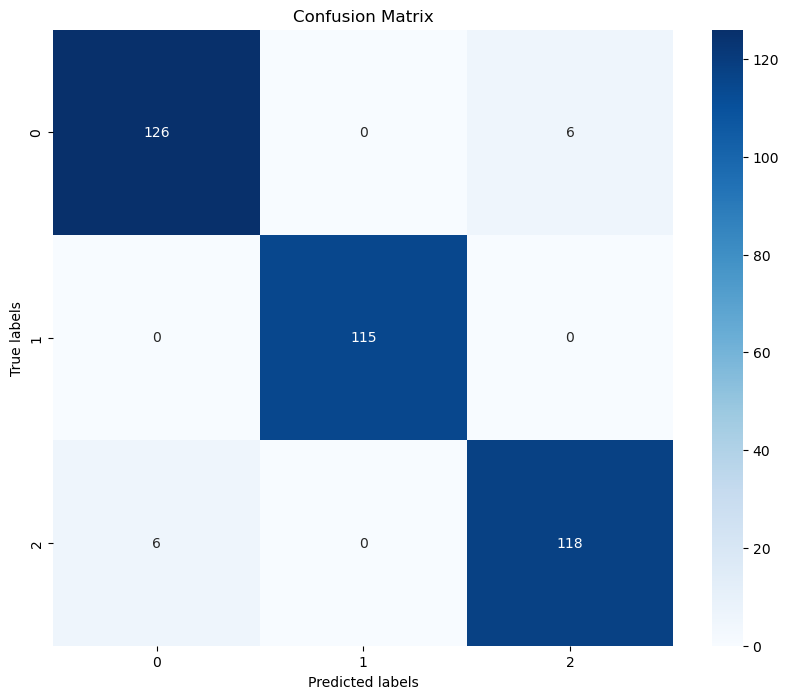

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## random forest classifier used for self training

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# model evaluation
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9532293986636972
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       160
           1       1.00      1.00      1.00       142
           2       0.91      0.95      0.93       147

    accuracy                           0.95       449
   macro avg       0.95      0.95      0.95       449
weighted avg       0.95      0.95      0.95       449

Confusion Matrix:
[[147   0  13]
 [  0 142   0]
 [  8   0 139]]


In [16]:
# # ROC and AUC
# prob = clf.predict_proba(X_test)[:,1]
# fpr, tpr, thresholds = roc_curve(y_test, prob)
# auc_value = auc(fpr, tpr)

# plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_value: .2f})')
# plt.plot([0,1], [0, 1], color='red', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel("True Positive Rate")
# plt.title('ROC Curve')
# plt.legend()
# plt.show()

In [19]:
from matplotlib import pyplot as plt

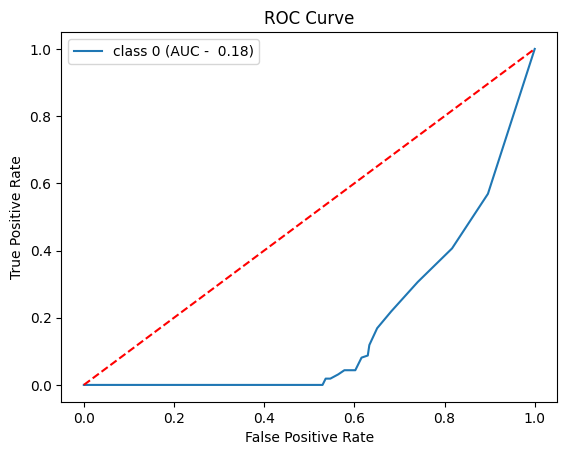

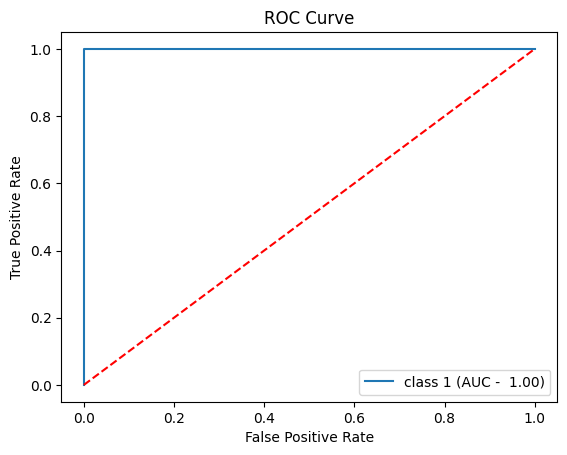

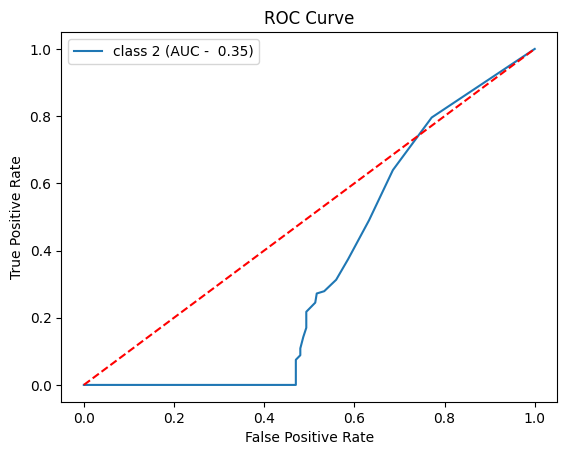

In [21]:
from sklearn.preprocessing import label_binarize

y_binarized = label_binarize(y_test, classes=np.unique(y_test))
prob = clf.predict_proba(X_test)
for i in range (y_binarized.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_binarized[:,i],prob[:,1])
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'class {i} (AUC - {auc_value: .2f})')
    plt.plot([0,1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig('ROC Curve')
    plt.show()

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Assuming df is your DataFrame with 26 features and 1 target variable
df = pd.read_csv('your_data.csv')

# Split data into labeled and unlabeled sets
labeled_df = df.dropna(subset=['target'])  # assuming target variable is not null for labeled data
unlabeled_df = df[df['target'].isnull()]

# Split labeled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(labeled_df.drop('target', axis=1), labeled_df['target'], test_size=0.2, random_state=42)

# Train an initial model on the labeled data
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
print("Initial Model Accuracy:", accuracy_score(y_test, y_pred))

# Self-training loop
for _ in range(5):  # number of iterations
    # Predict labels for unlabeled data
    unlabeled_pred = model.predict(unlabeled_df.drop('target', axis=1))
    unlabeled_pred_proba = model.predict_proba(unlabeled_df.drop('target', axis=1))
    
    # Select predicted labels with high confidence
    confidence_threshold = 0.8
    confident_pred = np.max(unlabeled_pred_proba, axis=1) > confidence_threshold
    new_labeled_data = unlabeled_df[confident_pred]
    new_labeled_data['target'] = unlabeled_pred[confident_pred]
    
    # Add new labeled data to the existing labeled dataset
    labeled_df = pd.concat([labeled_df, new_labeled_data])
    
    # Remove new labeled data from the unlabeled dataset
    unlabeled_df = unlabeled_df[~confident_pred]
    
    # Retrain the model on the updated labeled dataset
    X_train, X_test, y_train, y_test = train_test_split(labeled_df.drop('target', axis=1), labeled_df['target'], test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    print("Model Accuracy after self-training:", accuracy_score(y_test, y_pred))

# Using Neural Network
model_nn = Sequential()
model_nn.add(Dense(64, activation='relu', input_shape=(26,)))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dense(len(labeled_df['target'].unique()), activation='softmax'))
model_nn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the neural network model on the labeled data
model_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Self-training loop for neural network
for _ in range(5):  # number of iterations
    # Predict labels for unlabeled data
    unlabeled_pred_proba = model_nn.predict(unlabeled_df.drop('target', axis=1))
    unlabeled_pred = np.argmax(unlabeled_pred_proba, axis=1)
    
    # Select predicted labels with high confidence
    confidence_threshold = 0.8
    confident_pred = np.max(unlabeled_pred_proba, axis=1) > confidence_threshold
    new_labeled_data = unlabeled_df[confident_pred]
    new_labeled_data['target'] = unlabeled_pred[confident_pred]
    
    # Add new labeled data to the existing labeled dataset
    labeled_df = pd.concat([labeled_df, new_labeled_data])
    
    # Remove new labeled data from the unlabeled dataset
    unlabeled_df = unlabeled_df[~confident_pred]
    
    # Retrain the model on the updated labeled dataset
    X_train, X_test, y_train, y_test = train_test_split(labeled_df.drop('target', axis=1), labeled_df['target'], test_size=0.2, random_state=42)
    model_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    
    # Evaluate the model on the test set
    test_loss, test_acc = model_nn.evaluate(X_test, y_test)
    print("Neural Network Model Accuracy after self-training:", test_acc)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

In [1]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB()
clf.fit(X_train_fs, y)
CategoricalNB()
print(clf.predict(X[2:3]))

In [ ]:
  # display confusion matrix
  from sklearn.metrics import confusion_matrix
  y_predicteds = model.predict(test_x)
  cm = confusion_matrix(test_y, y_predicteds)
  print("Confusion matrix: ")
  print(cm)